# Cyber Intrution Detection using XGBoost

This project is designed to detecting cyber intrutions based on user behavior.
We will using dataset from **/kaggle/input/cybersecurity-intrusion-detection-dataset**  and develop XGBoost model for prediction.

# Data Exploration

First we loading the dataset and perform pre-processing data
1. Checking dataset summary
2. Checking missing value
3. Data manipulation
4. Correlation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv("/kaggle/input/cybersecurity-intrusion-detection-dataset/cybersecurity_intrusion_data.csv", index_col=0)

print(df1.head())
print(df1.info())
print(df1.isnull().sum())

            network_packet_size protocol_type  login_attempts  \
session_id                                                      
SID_00001                   599           TCP               4   
SID_00002                   472           TCP               3   
SID_00003                   629           TCP               3   
SID_00004                   804           UDP               4   
SID_00005                   453           TCP               5   

            session_duration encryption_used  ip_reputation_score  \
session_id                                                          
SID_00001         492.983263             DES             0.606818   
SID_00002        1557.996461             DES             0.301569   
SID_00003          75.044262             DES             0.739164   
SID_00004         601.248835             DES             0.123267   
SID_00005         532.540888             AES             0.054874   

            failed_logins browser_type  unusual_time_access 

In [2]:
# Reset index
df = df1.reset_index()

# Replace missing value
df= df.dropna()

print(df.head())
print(df.isnull().sum())
print (df.info())


  session_id  network_packet_size protocol_type  login_attempts  \
0  SID_00001                  599           TCP               4   
1  SID_00002                  472           TCP               3   
2  SID_00003                  629           TCP               3   
3  SID_00004                  804           UDP               4   
4  SID_00005                  453           TCP               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             DES             0.606818              1   
1       1557.996461             DES             0.301569              0   
2         75.044262             DES             0.739164              2   
3        601.248835             DES             0.123267              0   
4        532.540888             AES             0.054874              1   

  browser_type  unusual_time_access  attack_detected  
0         Edge                    0                1  
1      Firefox                    0 

Since our target is attacked_detected we will visualized the distribution and for checking the relationship with other features we generated correlation heatmap.

attack_detected
0    4217
1    3354
Name: count, dtype: int64


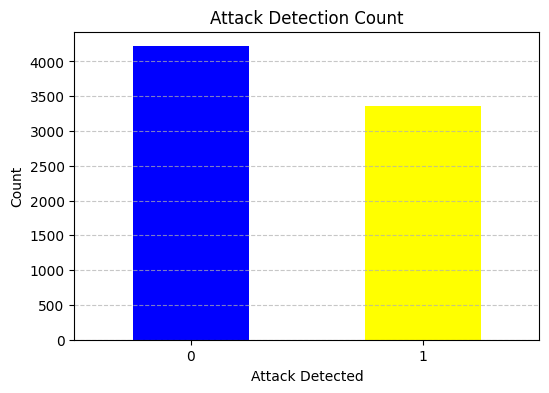

In [3]:
attack_counts = df.attack_detected.value_counts()
print(attack_counts)

plt.figure(figsize=(6,4))
attack_counts.plot(kind='bar', color=['blue', 'yellow'])
plt.xlabel("Attack Detected")
plt.ylabel("Count")
plt.title("Attack Detection Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()

We found the results as below :


* No Attack = 4217
* Attack = 3354


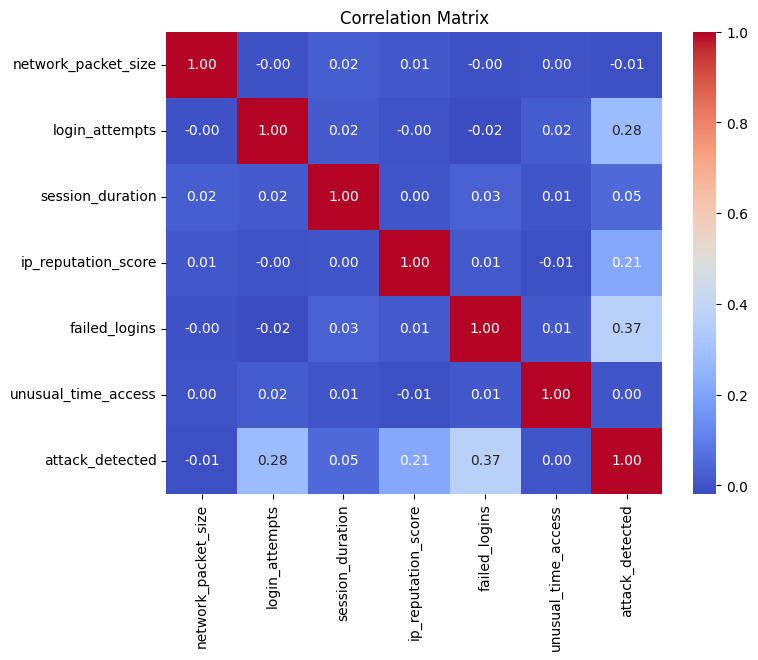

In [4]:
df_numeric = df.select_dtypes(include=np.number) 
df_numeric.corr()
plt.figure(figsize=(8,6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# MODEL DEVELOPMENT

In this step, we will defined the target variables and other features for predicting by looking at correlation. In this case, we have 2 kind of features that will be used to deploy our model.
1. Numerical_Features = login_attempts, ip_reputation_score, failed_logins
2. Categorical_Features = protocol type, encryption used, and browser type

After we separate the features, we need to transfor these features to ensuring that both feature types are processed correctly before training.
For numerical data, we used StandardScaler and for categorical data we use OneHotEncoder and finally we will creating a pipeline to develop XGBoost model.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor

# Features and target
features = ['login_attempts', 'ip_reputation_score', 'failed_logins', 'protocol_type', 'encryption_used', 'browser_type']
y = df['attack_detected']
X = df[features]

In [6]:
numerical_features = ['login_attempts', 'ip_reputation_score','failed_logins']
categorical_features = ['protocol_type','encryption_used','browser_type']
# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
#Develop XGBoost Model

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Full pipeline with XGBRegressor
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

In [8]:
#Evaluate model performance
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
mae_pipeline = mean_absolute_error(y_test, y_pred)
mse_pipeline = mean_squared_error(y_test, y_pred)
r2_pipeline = r2_score(y_test, y_pred)

print("MAE Score =" ,mae_pipeline)
print("MSE Score =" ,mse_pipeline)
print("R2 Score =" ,r2_pipeline)

MAE Score = 0.18413172776091016
MSE Score = 0.09180805130339281
R2 Score = 0.628339535181557


# Conclusion


* The model's average prediction error is 0.1841, in the same unit as the target.
* The MSE is lower than the MAE, meaning that large errors are not overly dominant in this model.
* The model explains 62.83% of the variability in the data.


# Improvement
* Add new features (Feature Engineering) to better capture patterns.
* Try different models such as Random Forest or Neural Networks.
* Use Hyperparameter Tuning (e.g., GridSearchCV).
